In [1]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.stats import SigmaClip
from photutils.background import Background2D, SExtractorBackground
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import little_things_functions as ltf
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
from matplotlib import cm
from scipy.fft import fft2, fftshift
import os
import numpy as np
from astropy.io import fits
from skimage.transform import AffineTransform, warp
import matplotlib.pyplot as plt
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import LogStretch
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# DDO 101

(705, 681)


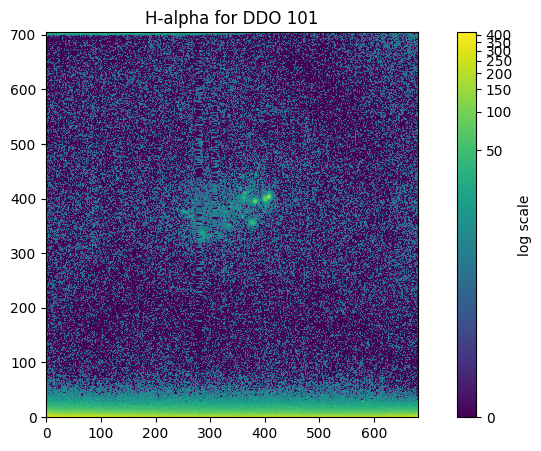

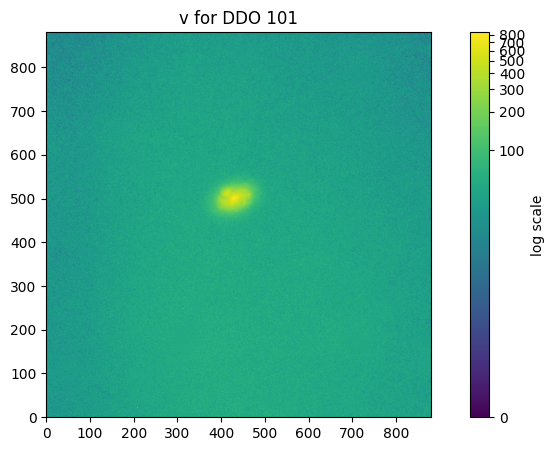

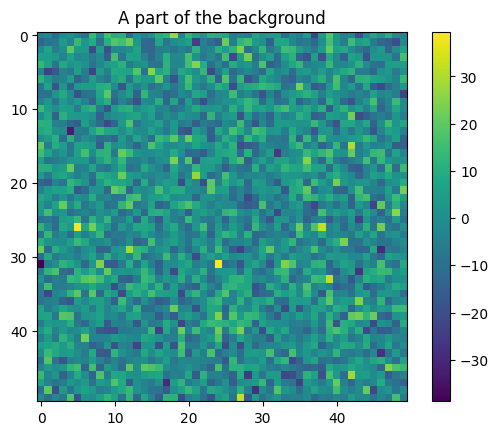

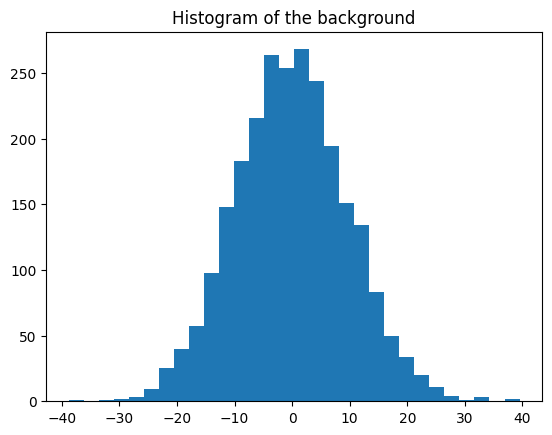

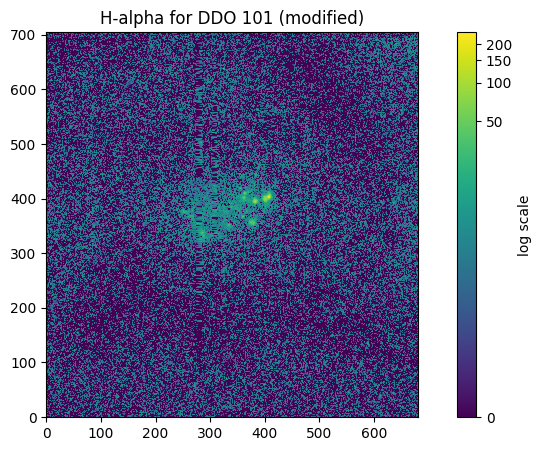

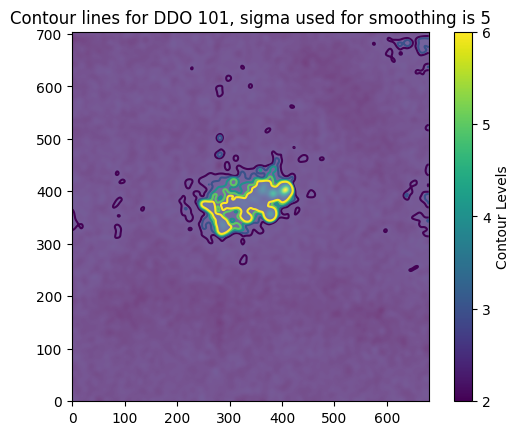

In [2]:
galaxy_name = "DDO 101"
DDO101_H = ltf.open_fits(r"c:\Users\AYSAN\Desktop\project\Galaxy\Data\DDO 101\d101hmrms.fits")
DDO101_V = ltf.open_fits(r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\d101\starless_backgroundless_d101v_aligned.fits.fit")
print(np.shape(DDO101_H))
# Trim the image
DDO101_H_trimmed = DDO101_H[80: -10]
ltf.log_scale_plot(DDO101_H, f"H-alpha for {galaxy_name}", "log scale")
ltf.log_scale_plot(DDO101_V, f"v for {galaxy_name}", "log scale")

# Generate the replacement values from a normal distribution
chunk = DDO101_H[100:150, 400:450]
mean = np.mean(chunk)
std_dev = np.std(chunk)

# Create a full array with replacement values
DDO101_H_replaced = np.random.normal(loc=mean, scale=std_dev, size=DDO101_H.shape)

# Copy the trimmed portion back into the original image shape
DDO101_H_replaced[80:-10, :] = DDO101_H_trimmed

# For visual confirmation, plot the chunk histogram
plt.imshow(chunk)
plt.title("A part of the background")
plt.colorbar()
plt.show()
plt.hist(chunk.flatten(), bins=30)
plt.title("Histogram of the background")
#plt.show()
# Plot the modified data
ltf.log_scale_plot(DDO101_H_replaced, f"H-alpha for {galaxy_name} (modified)", "log scale")
'''
plt.hist(DDO101_H)
plt.show()
'''
sigma = 5

# Assuming DDO101_H_replaced is already defined
smoothed = gaussian_filter(DDO101_H_replaced, sigma)

fig, ax = plt.subplots()
im = ax.imshow(smoothed, alpha=0.75, origin="lower")

# Create the contour plot
levels = [2, 3, 4, 5, 6]
CS = ax.contour(smoothed, levels, cmap='viridis')

# Create a custom color bar for the contour lines
norm = Normalize(vmin=2, vmax=6)  # Adjust this range according to your contour levels
sm = cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

# Add the color bar with labels
cbar = fig.colorbar(sm, ax=ax, ticks=levels)
cbar.ax.set_yticklabels([str(level) for level in levels])
cbar.set_label('Contour Levels')

plt.title(f"Contour lines for {galaxy_name}, sigma used for smoothing is {sigma}")
plt.show()

# Specify the output directory and file name
output_dir = r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\d101"
output_path = os.path.join(output_dir, "DDO101_H_replaced.fits")

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the replaced array to a new FITS file
fits.writeto(output_path, DDO101_H_replaced.astype(np.float32), overwrite=True)



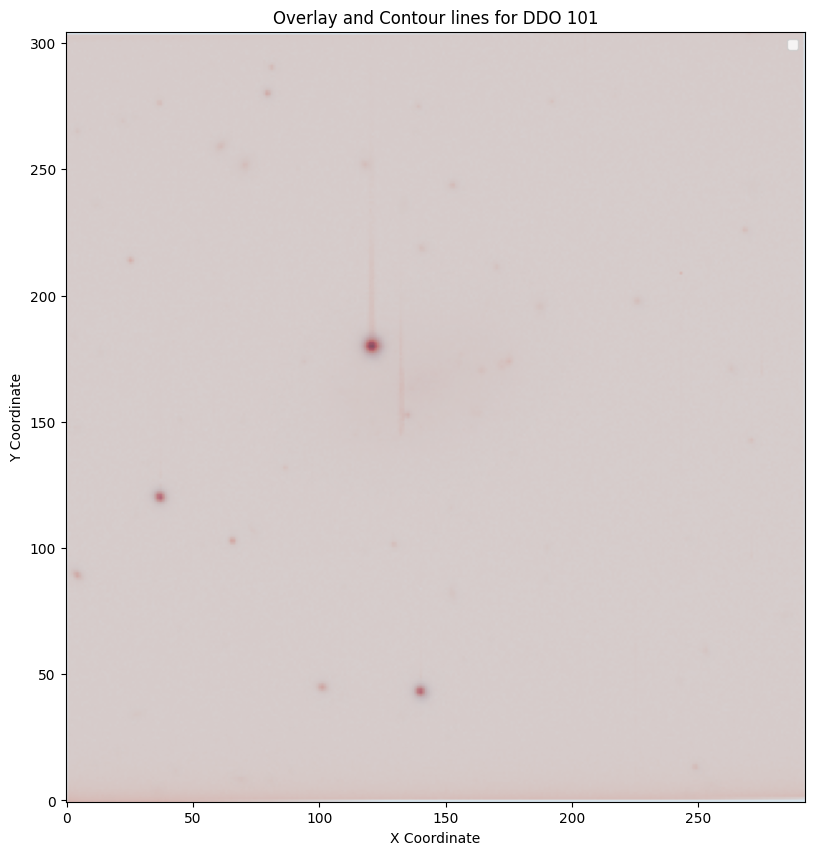

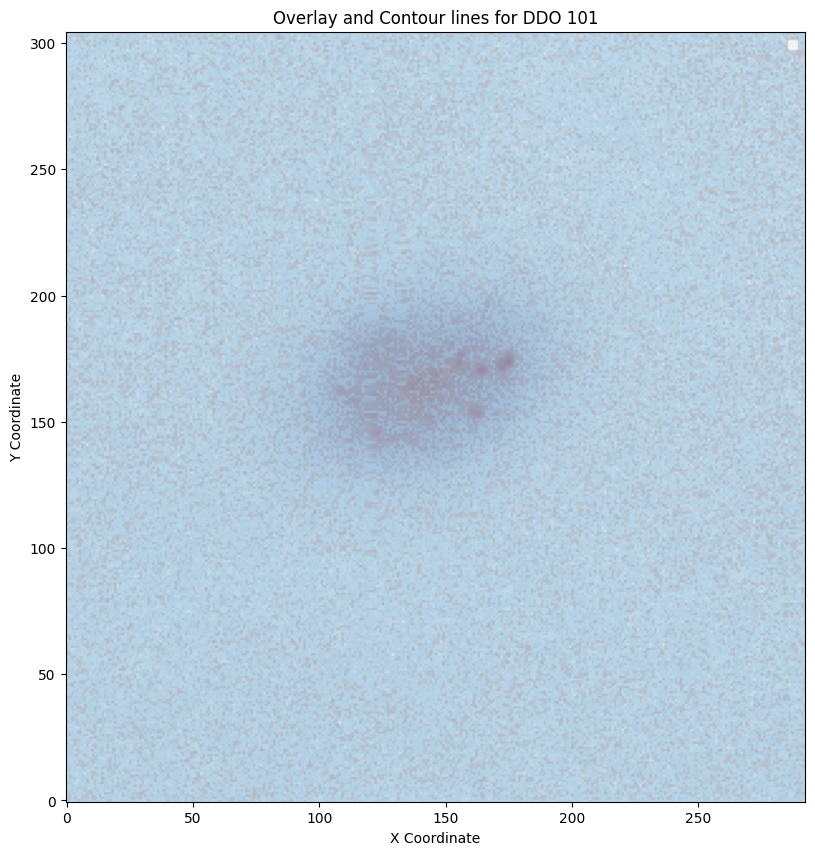

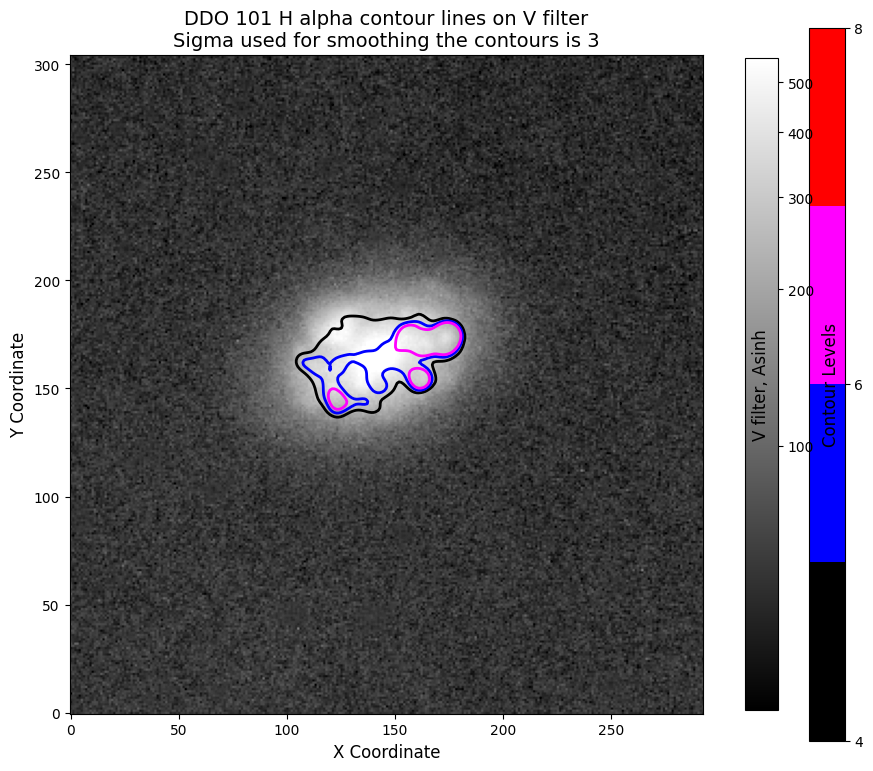

H-alpha pixelscale: 0.48737796312686305
new pixelscale is:  1.1264509308188861


In [3]:
image1_path = r"C:\Users\AYSAN\Desktop\project\Galaxy\Data\DDO 101\d101v.fits"
image2_path = r"C:\Users\AYSAN\Desktop\project\Galaxy\Data\DDO 101\d101ha.fits"
output_dir = r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\d101"
star_coords_V = np.array([[327, 456], [411, 515], [430, 379]])
star_coords_H = np.array([[86, 281], [282, 417], [326, 101]])
star_coords_V_new = np.array([[37,121],[121,181],[141,44]])
V_with_stars, H_with_stars = ltf.V_and_Halpha_alignment(galaxy_name, image1_path, image2_path, star_coords_V, star_coords_H, output_dir, alpha1=0.5, alpha2=0.5)

image1_path = r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\d101\starless_backgroundless_d101v_aligned.fits.fit"
image2_path = r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\d101\DDO101_H_replaced.fits"
V_pixelscale = 1.134
V_image , H_image = ltf.V_and_Halpha_alignment(galaxy_name, image1_path, image2_path, star_coords_V, star_coords_H, output_dir, alpha1=0.5, alpha2=0.2)
ltf.plot_contours_V_and_Halpha(galaxy_name, V_image, H_image, folder_path=r"C:\Users\AYSAN\Desktop\project\Galaxy\H-alpha regions", alpha=1, sigma=3, contour_levels=[4, 6, 8])
H_pixelscale = ltf.calculate_pixelscale(star_coords_V, star_coords_H, V_pixelscale)
new_pixelscale = ltf.calculate_pixelscale(star_coords_V, star_coords_V_new, V_pixelscale)
print("H-alpha pixelscale:", H_pixelscale)
print("new pixelscale is: ", new_pixelscale)

# Resolution DDO 101

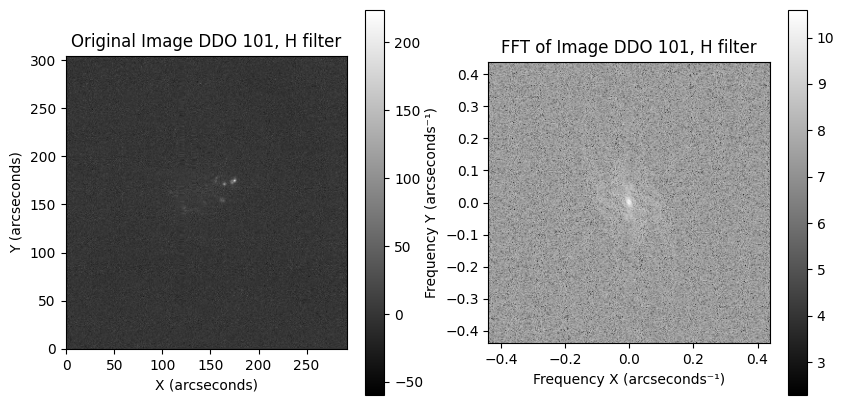

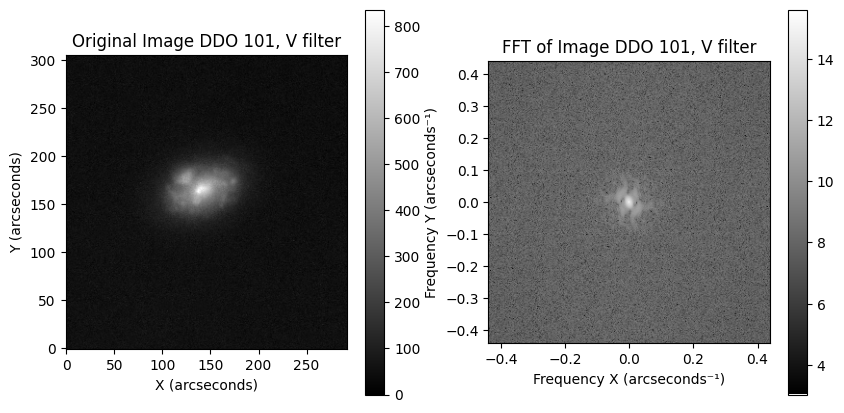

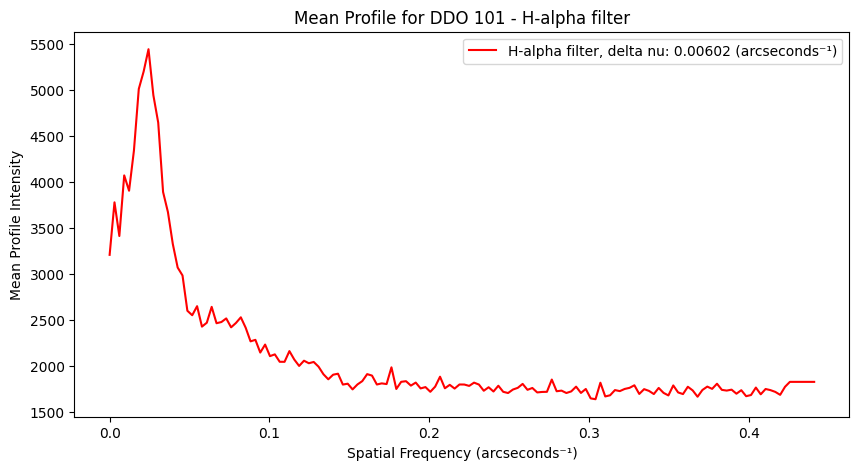

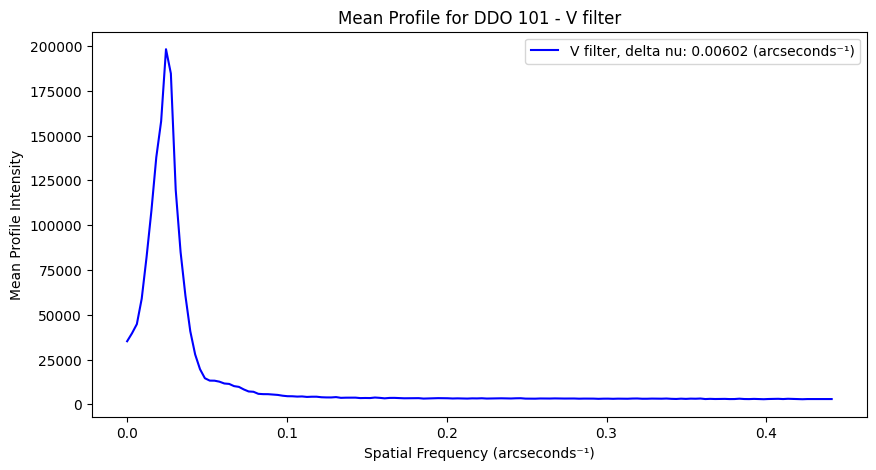

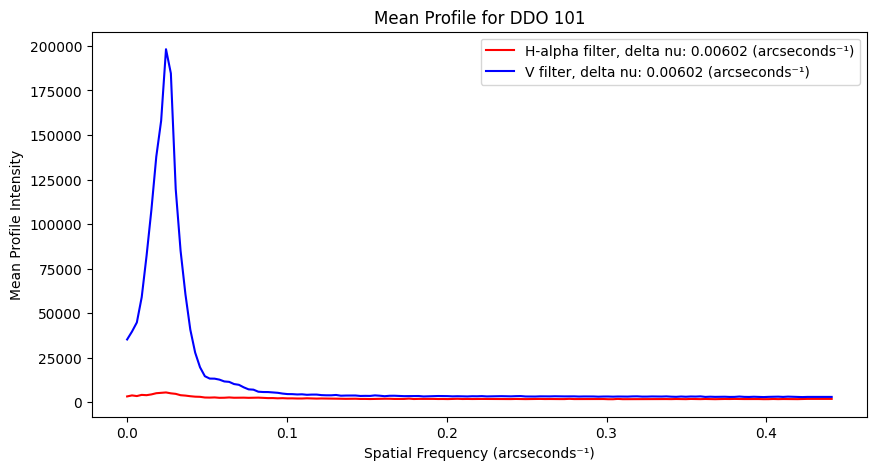

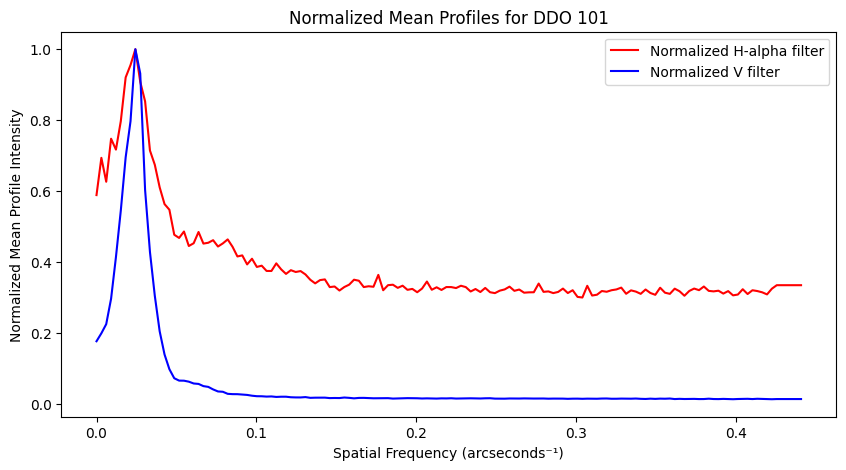

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt

def forward_fill(arr):
    mask = np.isnan(arr)
    arr[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), arr[~mask])
    return arr

def resolution_profiles(H_image, V_image, galaxy_name, pixelscale, output_dir):
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Compute profiles for H-alpha image
    profiles_H, mean_profile_H, length_H = ltf.resolution(H_image, galaxy_name, "H", num_theta=360, pixelscale=pixelscale)
    image_shape_H = H_image.shape
    x_ax_H = np.linspace(0, 1 / (2 * pixelscale), length_H)
    delta_nu_H = np.round(2 / (image_shape_H[1] * pixelscale), 5)

    # Compute profiles for V filter image
    profiles_V, mean_profile_V, length_V = ltf.resolution(V_image, galaxy_name, "V", num_theta=360, pixelscale=pixelscale)
    image_shape_V = V_image.shape
    x_ax_V = np.linspace(0, 1 / (2 * pixelscale), length_V)
    delta_nu_V = np.round(2 / (image_shape_V[1] * pixelscale), 5)

    # Replace NaNs with the last non-NaN value
    mean_profile_H = forward_fill(mean_profile_H)
    mean_profile_V = forward_fill(mean_profile_V)

    # Plot individual profile for H-alpha image
    plt.figure(figsize=(10, 5))
    plt.plot(x_ax_H, mean_profile_H, label=f'H-alpha filter, delta nu: {delta_nu_H} (arcseconds⁻¹)', color='red')
    plt.xlabel('Spatial Frequency (arcseconds⁻¹)')
    plt.ylabel('Mean Profile Intensity')
    plt.title(f'Mean Profile for {galaxy_name} - H-alpha filter')
    plt.legend()
    plt.show()

    # Plot individual profile for V filter image
    plt.figure(figsize=(10, 5))
    plt.plot(x_ax_V, mean_profile_V, label=f'V filter, delta nu: {delta_nu_V} (arcseconds⁻¹)', color='blue')
    plt.xlabel('Spatial Frequency (arcseconds⁻¹)')
    plt.ylabel('Mean Profile Intensity')
    plt.title(f'Mean Profile for {galaxy_name} - V filter')
    plt.legend()
    plt.show()

    # Plot both profiles on the same plot and save to specified folder path
    plt.figure(figsize=(10, 5))
    plt.plot(x_ax_H, mean_profile_H, label=f'H-alpha filter, delta nu: {delta_nu_H} (arcseconds⁻¹)', color='red')
    plt.plot(x_ax_V, mean_profile_V, label=f'V filter, delta nu: {delta_nu_V} (arcseconds⁻¹)', color='blue')
    plt.xlabel('Spatial Frequency (arcseconds⁻¹)')
    plt.ylabel('Mean Profile Intensity')
    plt.title(f'Mean Profile for {galaxy_name}')
    plt.legend()
    output_path = os.path.join(output_dir, f'combined_resolution_profiles_for_{galaxy_name}.png')
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    plt.show()

    # Normalize the profiles
    norm_mean_profile_H = mean_profile_H / np.max(mean_profile_H)
    norm_mean_profile_V = mean_profile_V / np.max(mean_profile_V)

    # Plot normalized profiles on top of each other
    plt.figure(figsize=(10, 5))
    plt.plot(x_ax_H, norm_mean_profile_H, label='Normalized H-alpha filter', color='red')
    plt.plot(x_ax_V, norm_mean_profile_V, label='Normalized V filter', color='blue')
    plt.xlabel('Spatial Frequency (arcseconds⁻¹)')
    plt.ylabel('Normalized Mean Profile Intensity')
    plt.title(f'Normalized Mean Profiles for {galaxy_name}')
    plt.legend()
    output_path_norm = os.path.join(output_dir, f'normalized_combined_resolution_profiles_for_{galaxy_name}.png')
    plt.savefig(output_path_norm, bbox_inches='tight', dpi=300)
    plt.show()

# Example usage:
resolution_profiles(H_image, V_image, galaxy_name, V_pixelscale, r"C:\Users\AYSAN\Desktop\project\Galaxy\Resolution")



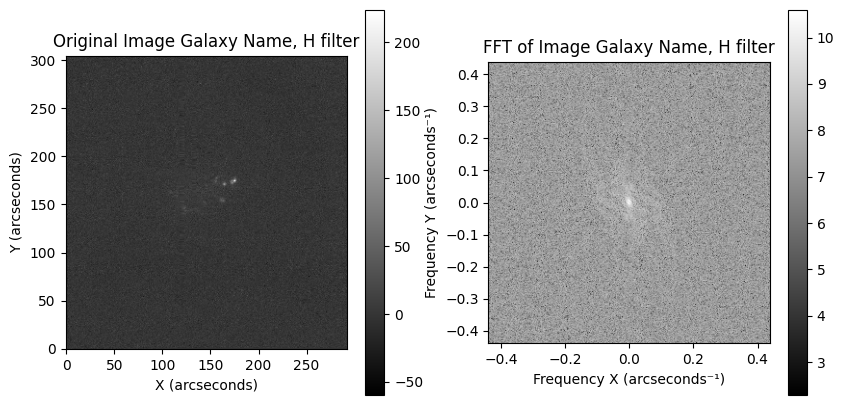

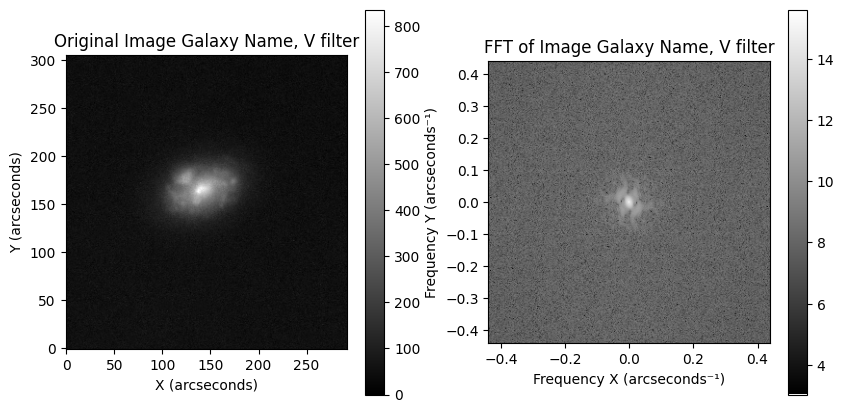

NaNs or Infinities detected in H-alpha profile
NaNs or Infinities detected in V profile


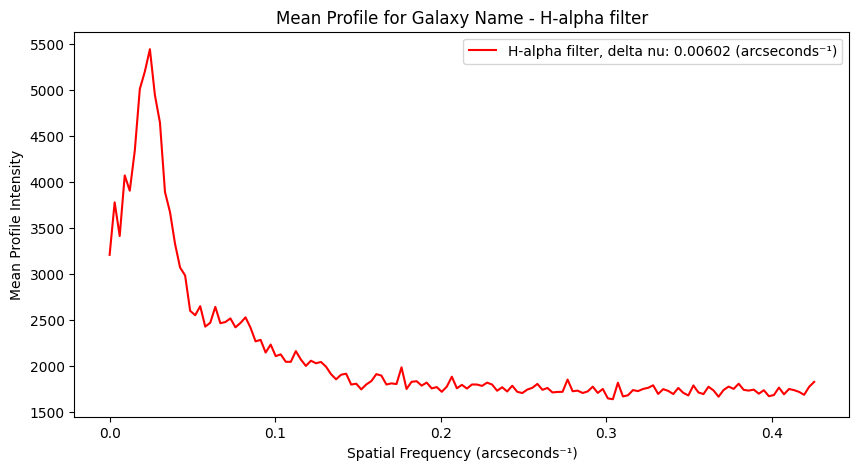

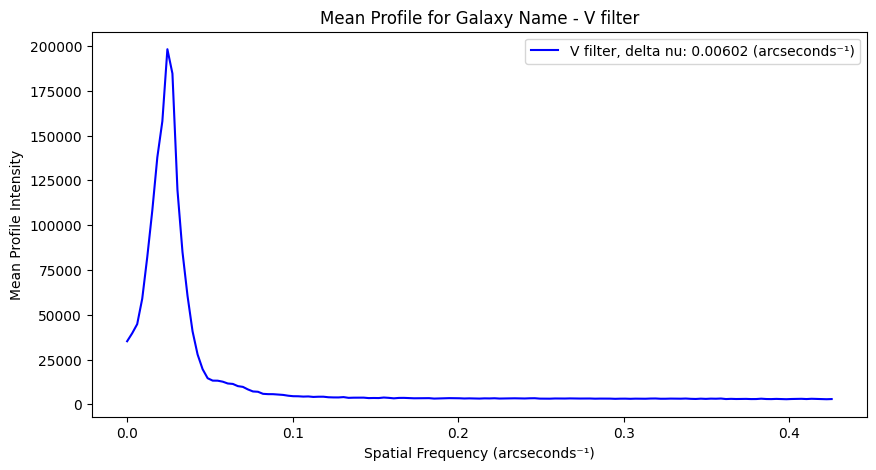

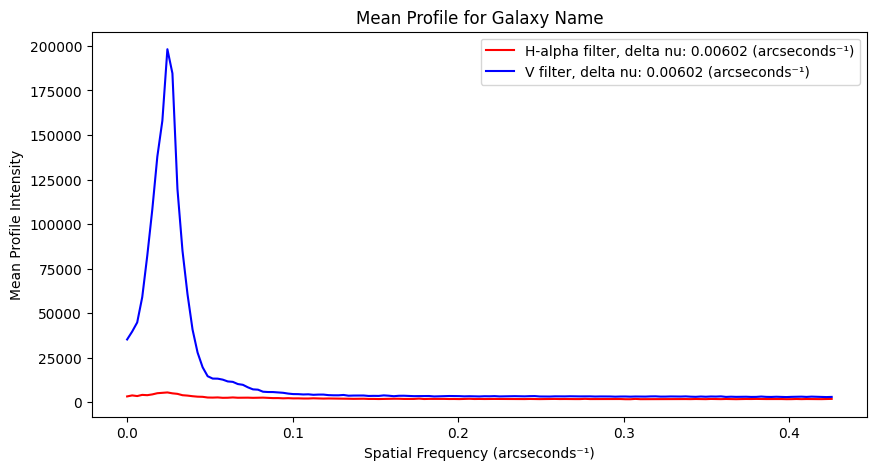

Invalid max value in H-alpha profile
Invalid max value in V profile
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


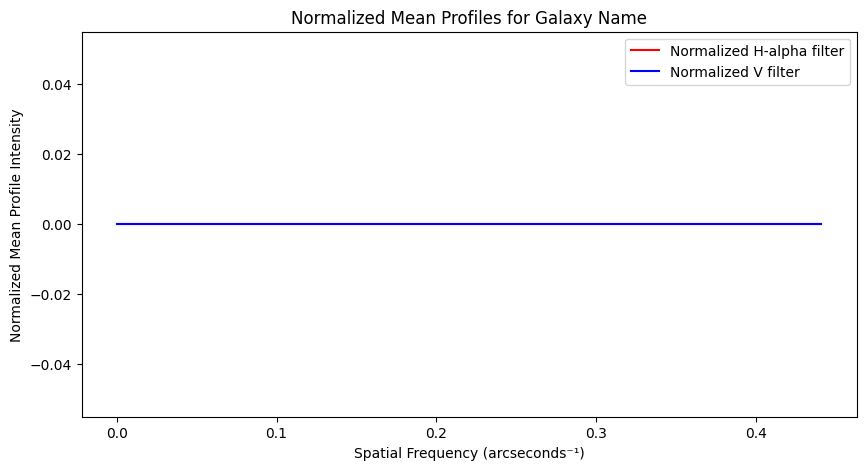

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt

def resolution_profiles(H_image, V_image, galaxy_name, pixelscale, output_dir):
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Compute profiles for H-alpha image
    profiles_H, mean_profile_H, length_H = ltf.resolution(H_image, galaxy_name, "H", num_theta=360, pixelscale=pixelscale)
    image_shape_H = H_image.shape
    x_ax_H = np.linspace(0, 1 / (2 * pixelscale), length_H)
    delta_nu_H = np.round(2 / (image_shape_H[1] * pixelscale), 5)

    # Compute profiles for V filter image
    profiles_V, mean_profile_V, length_V = ltf.resolution(V_image, galaxy_name, "V", num_theta=360, pixelscale=pixelscale)
    image_shape_V = V_image.shape
    x_ax_V = np.linspace(0, 1 / (2 * pixelscale), length_V)
    delta_nu_V = np.round(2 / (image_shape_V[1] * pixelscale), 5)

    # Check for NaNs or Infinities in initial profiles
    if np.isnan(mean_profile_H).any() or np.isinf(mean_profile_H).any():
        print("NaNs or Infinities detected in H-alpha profile")
    if np.isnan(mean_profile_V).any() or np.isinf(mean_profile_V).any():
        print("NaNs or Infinities detected in V profile")

    # Plot individual profile for H-alpha image
    plt.figure(figsize=(10, 5))
    plt.plot(x_ax_H, mean_profile_H, label=f'H-alpha filter, delta nu: {delta_nu_H} (arcseconds⁻¹)', color='red')
    plt.xlabel('Spatial Frequency (arcseconds⁻¹)')
    plt.ylabel('Mean Profile Intensity')
    plt.title(f'Mean Profile for {galaxy_name} - H-alpha filter')
    plt.legend()
    plt.show()

    # Plot individual profile for V filter image
    plt.figure(figsize=(10, 5))
    plt.plot(x_ax_V, mean_profile_V, label=f'V filter, delta nu: {delta_nu_V} (arcseconds⁻¹)', color='blue')
    plt.xlabel('Spatial Frequency (arcseconds⁻¹)')
    plt.ylabel('Mean Profile Intensity')
    plt.title(f'Mean Profile for {galaxy_name} - V filter')
    plt.legend()
    plt.show()

    # Plot both profiles on the same plot and save to specified folder path
    plt.figure(figsize=(10, 5))
    plt.plot(x_ax_H, mean_profile_H, label=f'H-alpha filter, delta nu: {delta_nu_H} (arcseconds⁻¹)', color='red')
    plt.plot(x_ax_V, mean_profile_V, label=f'V filter, delta nu: {delta_nu_V} (arcseconds⁻¹)', color='blue')
    plt.xlabel('Spatial Frequency (arcseconds⁻¹)')
    plt.ylabel('Mean Profile Intensity')
    plt.title(f'Mean Profile for {galaxy_name}')
    plt.legend()
    output_path = os.path.join(output_dir, f'combined_resolution_profiles_for_{galaxy_name}.png')
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    plt.show()

    # Normalize the profiles
    if np.max(mean_profile_H) == 0 or np.isnan(np.max(mean_profile_H)) or np.isinf(np.max(mean_profile_H)):
        print("Invalid max value in H-alpha profile")
        norm_mean_profile_H = np.zeros_like(mean_profile_H)
    else:
        norm_mean_profile_H = mean_profile_H / np.max(mean_profile_H)

    if np.max(mean_profile_V) == 0 or np.isnan(np.max(mean_profile_V)) or np.isinf(np.max(mean_profile_V)):
        print("Invalid max value in V profile")
        norm_mean_profile_V = np.zeros_like(mean_profile_V)
    else:
        norm_mean_profile_V = mean_profile_V / np.max(mean_profile_V)

    # Print for debugging
    print(norm_mean_profile_H)
    print(norm_mean_profile_V)

    # Plot normalized profiles on top of each other
    plt.figure(figsize=(10, 5))
    plt.plot(x_ax_H, norm_mean_profile_H, label='Normalized H-alpha filter', color='red')
    plt.plot(x_ax_V, norm_mean_profile_V, label='Normalized V filter', color='blue')
    plt.xlabel('Spatial Frequency (arcseconds⁻¹)')
    plt.ylabel('Normalized Mean Profile Intensity')
    plt.title(f'Normalized Mean Profiles for {galaxy_name}')
    plt.legend()
    output_path_norm = os.path.join(output_dir, f'normalized_combined_resolution_profiles_for_{galaxy_name}.png')
    plt.savefig(output_path_norm, bbox_inches='tight', dpi=300)
    plt.show()

# Example usage:
resolution_profiles(H_image, V_image, "Galaxy Name", V_pixelscale, "output_directory")


# RD

In [5]:
list_of_ellipse_data = [0,0,0]
m = np.tan(list_of_ellipse_data [0])

def get_line_values(image,x_ax, center_of_galaxy_y, center_of_galaxy_x):
    values = []
    for x in x_ax:
        y = int(m * (x) + center_of_galaxy_y - m*center_of_galaxy_x)
        values.append(image[y, x])
        image[y,x] = 3000 
    return values

#or

def get_line_values(image,x_ax, center_of_galaxy_y, center_of_galaxy_x):
    values = []
    for x in x_ax:
        y = int(-1/m * (x) + center_of_galaxy_y - (-1/m)*center_of_galaxy_x)
        values.append(image[y, x])
        image[y, x] = 3000            
    return values

# choose depending of Theta and positioning of major axis 


def R_D(image, list_of_ellipse_data, center_of_galaxy_x, center_of_galaxy_y, start_of_galaxy_x, show_line_plot= True, initial_guesses = [1, 0.06, 25, 0]):
    #ellipse_data = [theta, a (size of galaxy), b (size of galaxy)]
    x_ax_left = np.arange(start_of_galaxy_x, center_of_galaxy_x)
    x_ax_right = np.arange(center_of_galaxy_x, (center_of_galaxy_x-start_of_galaxy_x) + center_of_galaxy_x)
    values_along_line_left = get_line_values(image, center_of_galaxy_y, x_ax_left)
    values_along_line_right = get_line_values(image, center_of_galaxy_y, x_ax_right)

    if show_line_plot == True:
        im = ax.imshow(image, cmap='gray' , origin = "lower", norm = norm)
        cbar = plt.colorbar(im, ax = ax)
        cbar.set_label("log scale")
        angle_in_degrees = np.degrees(list_of_ellipse_data[0])
        # Create the ellipse
        ellipse = Ellipse(xy=(center_of_galaxy_x, center_of_galaxy_y), width=2*list_of_ellipse_data[1], height=2*list_of_ellipse_data[2], angle=np.degrees(theta), edgecolor='r', facecolor='none', linewidth=2)
        # Add the ellipse to the axis
        ax.add_patch(ellipse)
        plt.title(f"Schematic view of a profile of {galaxy_name} along major axis")
    else:
        pass

    values_along_line = values_along_line_left + values_along_line_right
    x_ax = np.arange(np.min(x_ax_left), np.max(x_ax_right)+1)
    plt.scatter(x_ax , values_along_line, s = 3, label='values along the major axis')
    plt.plot(x_ax , values_along_line, color = "black" , linewidth = 0.5)
    plt.title(f"Light profile for{galaxy_name} along the major axis.")
    plt.axvline(x=center_of_galaxy_x, color='r', linestyle='--', label='center of the fitted ellipse')
    plt.legend()

    L = len(x_ax_left)
    new_x_ax_right = []
    for i in range(0,len(x_ax_right)):
        x = (2*L-x_ax_right[i] + start_of_galaxy_x*2)
        new_x_ax_right.append(x)
    
    plt.scatter(x_ax_left , values_along_line_left, s = 3, label='values along the left side of the major axis')
    plt.scatter(new_x_ax_right , values_along_line_right, s = 3, label='values along the right side of the major axis')
    plt.axvline(x=center_of_galaxy_x, color='r', linestyle='--', label='center of the fitted ellipse')
    plt.legend()
 
    def exponential_func(x, a, b, c, x0):
        return a * np.exp(b * (x - x0)) + c
    
    x1 = x_ax_left # Your x values
    x2 = new_x_ax_right
    y1 = values_along_line_left
    y2 = values_along_line_right
    # Combine y-values
    y_combined = np.concatenate((y1, y2))
    x_combined = np.concatenate((x1, x2))
    # Provide initial guesses for the parameters
    popt, pcov = curve_fit(exponential_func, x_combined, y_combined, p0=initial_guesses)

    # Plot the original data and the fitted function
    plt.figure(figsize=(10, 8))

    plt.subplot(2, 1, 1)
    plt.scatter(x_combined, y_combined, s=3, label='Data')
    plt.plot(x_combined, exponential_func(x_combined, *popt), label='Fitted function', color='red')
    plt.axvline(x=center_of_galaxy_x, color='r', linestyle='--', label='Center of the fitted ellipse')
    plt.legend()
    plt.title(f'{galaxy_name} light profile and fitted function')

    # Calculate residuals
    residuals = y_combined - exponential_func(x_combined, *popt)

    # Plot the residuals
    plt.subplot(2, 1, 2)
    plt.scatter(x_combined, residuals, s=3, label='Residuals')
    plt.axhline(0, color='red', linestyle='--')
    plt.legend()
    plt.title('Residuals')
    plt.xlabel('x')
    plt.ylabel('Residuals')
    plt.tight_layout()
    plt.show()

    # Calculate the standard deviation errors on the parameters
    perr = np.sqrt(np.diag(pcov))
    print("Exponential fit function is a * exp(b * (x - x0)) + c")
    print(f"a is {popt[0]:.4f} +/- {perr[0]:.4f}")
    print(f"b is {popt[1]:.4f} +/- {perr[1]:.4f}")
    print(f"c is {popt[2]:.4f} +/- {perr[2]:.4f}")
    print(f"x0 is {popt[3]:.4f} +/- {perr[3]:.4f}")

    print(f"b is {popt[1]:.4f} +/- {perr[1]:.4f}")
    print(f"1/b is {1/popt[1]:.4f}")
    